**Assignment Week 9**

Due: 3/18/2024

Shimon Greengart

First, I get the data.

In [ ]:
import numpy as np
from tensorflow import keras as kr
from sklearn import model_selection, metrics, manifold
import matplotlib.pyplot as plt

(X, Y), (X_test, Y_test) = kr.datasets.mnist.load_data()

X_tsne = X.reshape((X.shape[0], 784)).astype('float32')

# train-validation-test split
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y)
# I pass it in as a 2D array
# I need to divide it by 255, because my output is a float from 0 to 1, and otherwise, the input won't be comparable
# So I would get ridiculous losses and no training
X_train = X_train.reshape((X_train.shape[0], 28, 28)).astype('float32') / 255
X_test = X_test.reshape((X_test.shape[0], 28, 28)).astype('float32') / 255
X_val = X_val.reshape((X_val.shape[0], 28, 28)).astype('float32') / 255


Here, I use t-SNE to map the different numbers in the train and validation sets. One of the things I noticed is that all of the number groups are sprinkled with different colors - other numbers that don't belong here. This means that it's inherently difficult to get a perfect sort, no matter how good of a CNN I have.

But some of the numbers have their entire group merging with another. For example, 7 is merging with 9, 9 is merging with 4, and 5, 8, and 3 are all merging with each other. These all show numbers that my model commonly confused for each other, since there is some overlap in the basic definition.

Legend - 0: maroon, 1: red, 2: orange, 3: yellow, 4: lime, 5: green, 6: cyan, 7: blue, 8: purple, 9: magenta


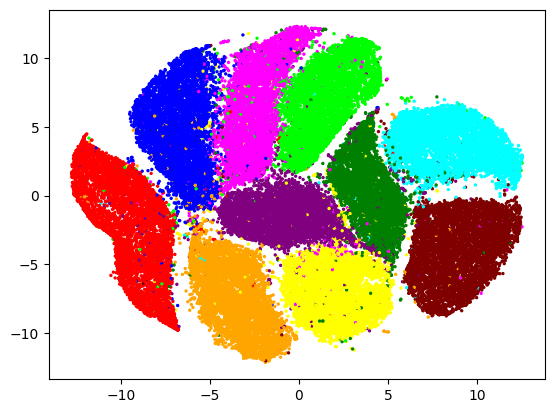

In [ ]:
color_options = ['maroon', 'red', 'orange', 'yellow', 'lime', 'green', 'cyan', 'blue', 'purple', 'magenta']
color = [color_options[i] for i in Y]

# print(X.shape)

tsne = manifold.TSNE(n_iter=300)
Y = tsne.fit_transform(X_tsne)

color_string = 'Legend - '
for i, c in enumerate(color_options):
    color_string += '%d: %s, ' % (i, c)
print(color_string[:-2])

plt.scatter(Y[:, 0], Y[:, 1], c=color, s=2.0)
plt.show()

Here, I have my autoencoder model.

I found that for this assignment, a higher learning rate of 0.001 led to faster training.

For both encoding and decoding, I used 2 dense layers: one of them compresses the input down to 180 nodes and another compresses it further down to 22. I found that until then, the output looked mostly the same as the input, but beyond that, it caused problems.

In [ ]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 25

SIDE_LEN = 28
FLAT_LEN = SIDE_LEN ** 2

MIDDLE_SIZE = 180
LIMINAL_SIZE = 22

# This is the stuff for the autoencoder
# I got the inheritance based on the link you gave me, but I wrote the encoder and decoder myself
class NumberAutoencoder(kr.models.Model):
    def __init__(self):
        super(NumberAutoencoder, self).__init__()
        self.encoder = kr.Sequential([
            kr.Input(shape=(SIDE_LEN, SIDE_LEN, 1)),
            # since I need it as an image for the before-and-after photos, it seemed more natural to change the shape inside the mode;
            kr.layers.Flatten(),
            kr.layers.Dense(MIDDLE_SIZE, activation='relu'),
            kr.layers.Dense(LIMINAL_SIZE, activation='relu')
        ])
        self.decoder = kr.Sequential([
            kr.Input(shape=(LIMINAL_SIZE)),
            kr.layers.Dense(MIDDLE_SIZE, activation='relu'),
            kr.layers.Dense(FLAT_LEN, activation='sigmoid'),
            kr.layers.Reshape((SIDE_LEN, SIDE_LEN))
            # We need to turn it back into a displayable image
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = NumberAutoencoder()

autoencoder.encoder.summary()
autoencoder.decoder.summary()

autoencoder.compile(optimizer=kr.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')  # since this is regression, not categorization

history = autoencoder.fit(X_train, X_train, epochs=NUM_EPOCHS, validation_data=(X_val, X_val),
                          callbacks=[kr.callbacks.EarlyStopping(monitor='val_loss', patience=0, start_from_epoch=5)])

# X_train and X_test for both, because we are testing the input by using it against itself

# With layer size 100, val_loss is 0.0082
# With no layer, val_loss is 0.0104, so, worse
# With layer size 150, val_loss is 0.0072.
# Let's try increasing to 200.



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 180)               141300    
                                                                 
 dense_1 (Dense)             (None, 22)                3982      
                                                                 
Total params: 145282 (567.51 KB)
Trainable params: 145282 (567.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 180)               4140      
                                                            

As you can see here, I got one of every number. The only real problems is that the 9 is a bit blurry and the 8 doesn't quite close. I found that the 8 was causing problems even with a middle layer that was much bigger. It's interesting that the 5, 6, and 3 actually look more like those numbers after my model than before it.

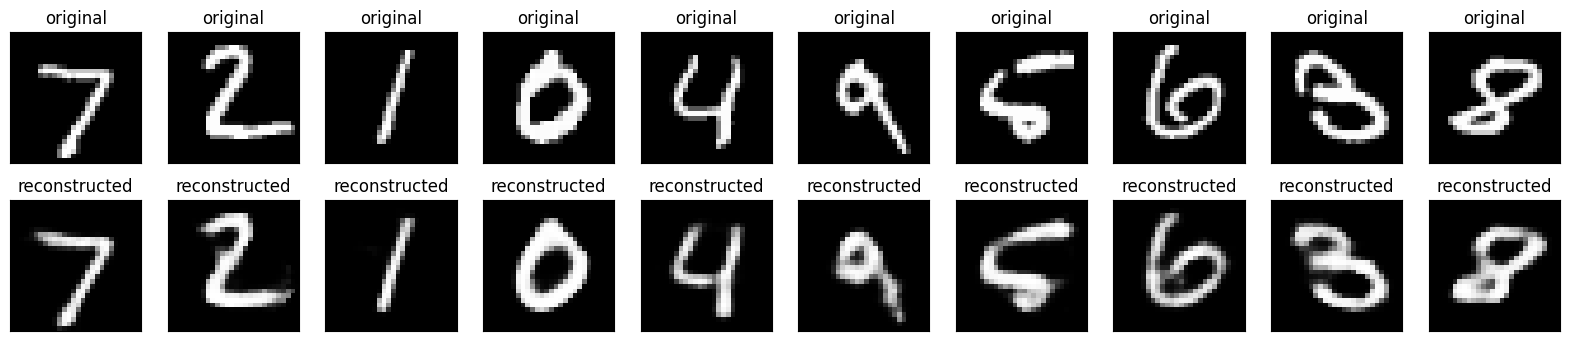

[ 0.99645716  2.094406    9.93512     3.6568558  10.91939     6.419233
 10.414231    0.49528578  6.778618    5.482153    5.91314     2.0811844
  7.7341013  11.282386    2.3528948   4.7912226   3.5730364   7.1588273
  0.27665585  3.3715024   8.71992     5.2041435 ]


In [ ]:
# import random

# temp = list(zip(X_test, Y_test))
# random.shuffle(temp)
# X_test, Y_test = zip(*temp)
# res1 and res2 come out as tuples, and so must be converted to lists.
# X_test, Y_test = list(X_test), list(Y_test)

# This code I actually copied off the website you gave us, since it's not the model itself
encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

seen_nums = set()
test_img_index = []
for i, num in enumerate(Y_test):
    if num not in seen_nums:
        seen_nums.add(num)
        test_img_index.append(i)
    if len(seen_nums) == 10:
        break


# print(seen_nums)
# print(test_img_index)
n = 10
plt.figure(figsize=(20, 4))
for i, img_i in enumerate(test_img_index):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[img_i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[img_i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

print(encoded_imgs[0])